In [0]:
# This cell prints GPU-Info using nvidia-smi to know what setup the model is running on

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Mar  8 13:02:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Allows plots generated by matplotlib inside the jupyter notebook

%matplotlib inline

In [0]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
from collections import deque
import time
import torch.utils.data.sampler as sampl
import random
import math
import itertools
import pickle
from google.colab import drive

In [0]:
# mounts google drive as file system to read and write from 
# ONLY USE WHEN CODE RUNS IN GOOGLE COLAB!

tuningResultsPath = F'/content/gdrive/My Drive/Bachelorarbeit/Tuning Results' 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
class ProgressiveBatchingLBFGS(optim.Optimizer):
  """Implements L-BFGS with an optional line search feature as well as two methods for dynamic batch size calculation.

  The progressive batching mechanism and initial step length calculation are based on the algorithm proposed 
  by Bollagrada et al. (2018) in the paper `A progressive Batching L-BFGS method for machine learning`.

  Args:
    params (iterable): iterable of parameters to optimize or dicts defining parameter groups
    progressive_batching (bool, optional): flag determining if progressive batching mechanism used (default: False)
    initial_batch_size (int, optional): batch size of the first iteration (default: 256)
    learning_rate (float, optional): learning rate (replaces line search) (default: None)
    max_iterations (int, optional): maximum number of optimization iterations performed per batch (default: 20)
    memory_size (int, optional): number of gradient pairs stored for L-BFGS update (default: 64)
    geometric_factor (int, optional): factor for geometricaly growing lower limit for batch size (effective if >1) (default: 0)
    theta (float, optional): constant between 0 and 1 used in the progressive batching mechanism (default: 0.9)
    division_threshold (float, optional): smallest denominator allowed for divisions to avoid divisions by 0 (default: 1e-32)
    armijo_alpha (float, optional): initial step length for line search (replaces initial step length calculation) (default: None)
    alpha_treshold (float, optional): smallest step length allowed in line search to avoid infinite loops (default: 1e-8)
    armijo_c (float, optional): constant between 0 and 1 - harshness of armijo condition (default: 0.5)
    armijo_tau (float, optional): constant between 0 and 1 - factor of decrease for step length candidates in line search (default: 0.5)
  
  """
  
  def __init__(self, params, progressive_batching=False, initial_batch_size=256, learning_rate=None, max_iterations=20, memory_size=64, 
                geometric_factor = 0, theta=0.9, division_threshold=1e-32, armijo_alpha=None, alpha_treshold=1e-8, armijo_c=0.5, armijo_tau=0.5):
    self.params = list(params)
    self.batch_size = initial_batch_size
    self.initial_batch_size = initial_batch_size
    self.learning_rate = learning_rate
    self.memory_size = memory_size
    self.theta = theta
    self.division_threshold = division_threshold
    self.armijo_alpha = armijo_alpha
    self.alpha_treshold = alpha_treshold
    self.armijo_c = armijo_c
    self.armijo_tau = armijo_tau
    self.progressive_batching = progressive_batching
    self.max_iterations = max_iterations
    self.geometric_factor = geometric_factor
    self.geometric_iterator = 0
    
    self._saved_vector_pairs = deque(maxlen=memory_size)
    self.x = None
    self.g = None
      
      
  def step(self, batch_closure, variance_closure=None):
    
    self.geometric_iterator += 1
    
    local_iterator = 0
    
    while(local_iterator < self.max_iterations):
    
        if local_iterator == 0:
            loss = batch_closure(True)

        local_iterator += 1

        self.x = nn.utils.parameters_to_vector(self.params).detach()
        self.g = nn.utils.parameters_to_vector(p.grad for p in self.params)

        try:
            p = self._get_LBFGS_Step(self.g, len(self.g))
        except self._LocalMinimumException:
            break

        if self.progressive_batching and self.armijo_alpha is None:
            if variance_closure is None:
                raise ValueError("variance_closure can't be None if progressive_batching is enabled")
            
            gradients = variance_closure()
        
            if self.armijo_alpha is None:
                try:
                    alpha = self._initial_armijo_steplength(gradients)
                except Exception as e:
                    print(str(e))
                    alpha = 1
        else:
            if self.armijo_alpha is None:
                alpha = 1
            else:
                alpha = self.armijo_alpha 
            
        # armijo line search, if no fixed learning rate is specified
        if self.learning_rate is None:
          self._armijo(self.x, p, self.g, alpha, batch_closure)
        else:
          nn.utils.vector_to_parameters(self.x + self.learning_rate * p , self.params)

        loss = batch_closure(True)

        # update x
        x_new = nn.utils.parameters_to_vector(self.params).detach()

        # update g
        g_new = nn.utils.parameters_to_vector(p.grad for p in self.params)

        # y is the difference of the gradients
        y = g_new - self.g
        
        # s is the actual step taken
        s = x_new - self.x

        # denom is the denominator used to calculate rho 
        denom = s.dot(y)

        # if denom == 0, we are "stuck" in a local minimum
        if denom < self.division_threshold:
            break

        # rho is needed for the next newton step
        rho = 1/denom

        # append calculated vector s and y as well as rho to list of saved vectors
        self._saved_vector_pairs.append((s, y, rho))

    if self.progressive_batching:
        if variance_closure is None:
            raise ValueError("variance_closure can't be None if progressive_batching is enabled")
        
        gradients = variance_closure()
        
        try:
            self.batch_size = max(self._getNewBatchSize(g_new, gradients), self.batch_size)
        except Exception as e:
            print(str(e))
        #print(f"newBatchSize = {self.batch_size}")
        
    self.batch_size = math.ceil(max(self.batch_size, self.initial_batch_size * (self.geometric_factor ** self.geometric_iterator)))
    
    return loss
      
      
  def _get_LBFGS_Step(self, q, size):
  
    gamma_k = 1

    if self._saved_vector_pairs:  

        (s_l, y_l, rho_l) = self._saved_vector_pairs[-1]

        local_denom = y_l.dot(y_l)

        if local_denom < self.division_threshold:
            raise self._LocalMinimumException()

        gamma_k = s_l.dot(y_l) / local_denom

    #H_k_0 = gamma_k * torch.eye(size)

    alpha_list = []

    for (s_i, y_i, rho_i) in reversed(self._saved_vector_pairs):

        alpha_i = rho_i * s_i.dot(q)

        q = q - alpha_i * y_i

        alpha_list.append(alpha_i)

    #r = H_k_0.mv(q)
    r = gamma_k * q

    for (s_j, y_j, rho_j), alpha_j in zip(self._saved_vector_pairs, reversed(alpha_list)):

        beta_j = rho_j * y_j.dot(r)

        r = r + s_j * (alpha_j - beta_j)

    return -r
  
  
  
  def _var_steplength(self, gradients):
      
    s = 0
    g = self.g
    
    for grad in gradients:
        diff = grad - g
        
        s += diff.dot(diff)
    
    return s / (len(gradients) - 1)
  
  
  
  def _initial_armijo_steplength(self, gradients):
    if len(gradients) == 0:
        raise ValueError("variance_batch can't be empty")
    elif len(gradients) == 1:
        return 1
    else:
        denom = self.batch_size * self.g.dot(self.g)
        
        if denom < self.division_threshold:
            print("Exception caused by denom < DIVISION_TRESHOLD")
            raise self._LocalMinimumException()
        
        inverse_alpha = 1 + (self._var_steplength(gradients) / denom)
        alpha = 1 / inverse_alpha
        #print(f"formula gives alpha = {alpha}")
        return alpha
  
  
    
  def _armijo(self, x, p, g, alpha, batch_closure):
    """searching for the first alpha that fullfills the armijo condition"""

    m = p.dot(g)

    initial_loss = batch_closure(False)
    
    nn.utils.vector_to_parameters(x + alpha * p , self.params)
    
    armijo_cond = batch_closure(False) <= initial_loss + alpha * self.armijo_c * m

    while not armijo_cond and alpha >= self.alpha_treshold:

        alpha *= self.armijo_tau
        
        nn.utils.vector_to_parameters(x + alpha * p , self.params)
        
        armijo_cond = batch_closure(False) <= initial_loss + alpha * self.armijo_c * m
    
    #print(f"Found steplength alpha = {alpha}")


  def _var_batchsize(self, grad_i, p_k_Sk, mu):
    p_k_i = self._get_LBFGS_Step(grad_i, len(p_k_Sk))
    return (p_k_i.dot(p_k_Sk) - mu)**2
  
  
  

  def _getNewBatchSize(self, g, gradients):
      
    if len(gradients) == 0:
        raise ValueError("variance_batch can't be empty")
    elif len(gradients) == 1:
        return self.initial_batch_size
    else:
        p = self._get_LBFGS_Step(g, len(g))
        mu = p.dot(p)
        if mu**2 < self.division_threshold:
            print("Exception caused by mu**2 < DIVISION_TRESHOLD")
            raise self._LocalMinimumException()

        denom = self.theta**2 * mu**2

        var = sum(self._var_batchsize(grad_i, p, mu) for grad_i in gradients) / (len(gradients) - 1)

        newBatchSize = math.ceil(var/denom)

        return newBatchSize
  
  
  
  
  class _LocalMinimumException(Exception):
    pass

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
class Timer(object):
    def __init__(self):
        self.times = []
        self._start_time = None
        
    @property
    def timeline(self):
        s = 0
        points = []
        for t in self.times:
            s += t
            points.append(s)
        return points
    
    def get_time(self):
        return sum(self.times)
    
    def start(self):
        self._start_time = time.time()
        
    def stop(self):
        self.times.append(time.time() - self._start_time)

In [0]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

plt.rcParams.update({'font.size': 16})
plotsPath = F'/content/gdrive/My Drive/Bachelorarbeit/Plots/' 

class Bookkeeper(object):
    
    def __init__(self):
        self.train_losses = []
        self.train_seen_data = []
        self.train_times = []
        self.train_grad_evals = []
        self.batch_sizes = []
        self.test_losses = []
        self.test_seen_data = []
        self.test_times = []
        self.test_grad_evals = []
        self.test_accuracies = []
        self.number_of_grad_evals = 0
        
    def document_test(self, loss, accuracy):
        self.test_losses.append(loss)
        self.test_seen_data.append(0 if not self.train_seen_data else self.train_seen_data[-1])
        self.test_times.append(0 if not self.train_times else self.train_times[-1])
        self.test_grad_evals.append(self.number_of_grad_evals)
        self.test_accuracies.append(accuracy)
        
    def document_training(self, loss, time, seen_data, batch_size):
        self.train_losses.append(loss)
        self.train_times.append(time)
        self.train_seen_data.append(seen_data)
        self.train_grad_evals.append(self.number_of_grad_evals)
        self.batch_sizes.append(batch_size)

    def document_grad_eval(self):
        self.number_of_grad_evals += 1

    def getData(self, xAxis, yAxis):
        if xAxis == "data":
          if yAxis == "test":
            return (self.test_seen_data, self.test_losses)
          elif yAxis == "accuracy":
            return (self.test_seen_data, self.test_accuracies)
          elif yAxis == "train":
            return (self.train_seen_data, self.train_losses)
        elif xAxis == "time":
          if yAxis == "test":
            return (self.test_times, self.test_losses)
          elif yAxis == "accuracy":
            return (self.test_times, self.test_accuracies)
          elif yAxis == "train":
            return (self.train_times, self.train_losses)
        elif xAxis == "gradients":
          if yAxis == "test":
            return (self.test_grad_evals, self.test_losses)
          elif yAxis == "accuracy":
            return (self.test_grad_evals, self.test_accuracies)
          elif yAxis == "train":
            return (self.train_grad_evals, self.train_losses)
          
    def plot_data_results(self, filename):
        fig, host = plt.subplots()

        par1 = host.twinx()
        par2 = host.twinx()
        par3 = host.twinx()

        par1.spines["right"].set_position(("axes", 1.45))
        make_patch_spines_invisible(par1)
        par1.spines["right"].set_visible(True)

        par3.spines["right"].set_position(("axes", 1.25))
        make_patch_spines_invisible(par3)
        par3.spines["right"].set_visible(True)

        p1, = host.plot(self.test_seen_data, self.test_losses, color='blue')
        p2, = par1.plot(self.train_seen_data, self.train_losses, color='red')
        p3, = par2.plot(self.train_seen_data, self.batch_sizes, color='green')
        p4, = par3.plot(self.test_seen_data, self.test_accuracies, color='cyan')

        host.set_xlabel('Number of training examples seen')
        host.set_ylabel('Test Loss')
        par1.set_ylabel('Train Loss')
        par2.set_ylabel('Batch Size')
        par3.set_ylabel('Accuracy')

        host.yaxis.label.set_color(p1.get_color())
        par1.yaxis.label.set_color(p2.get_color())
        par2.yaxis.label.set_color(p3.get_color())
        par3.yaxis.label.set_color(p4.get_color())

        
        plt.savefig(plotsPath + filename, dpi=150, bbox_inches='tight')

        plt.show()

    def plot_time_results(self, filename):
        fig, host = plt.subplots()

        par1 = host.twinx()
        par2 = host.twinx()
        par3 = host.twinx()

        par1.spines["right"].set_position(("axes", 1.45))
        make_patch_spines_invisible(par1)
        par1.spines["right"].set_visible(True)

        par3.spines["right"].set_position(("axes", 1.25))
        make_patch_spines_invisible(par3)
        par3.spines["right"].set_visible(True)

        p1, = host.plot(self.test_times, self.test_losses, color='blue')
        p2, = par1.plot(self.train_times, self.train_losses, color='red')
        p3, = par2.plot(self.train_times, self.batch_sizes, color='green')
        p4, = par3.plot(self.test_times, self.test_accuracies, color='cyan')

        host.set_xlabel('Training Time in Seconds')
        host.set_ylabel('Test Loss')
        par1.set_ylabel('Train Loss')
        par2.set_ylabel('Batch Size')
        par3.set_ylabel('Accuracy')

        host.yaxis.label.set_color(p1.get_color())
        par1.yaxis.label.set_color(p2.get_color())
        par2.yaxis.label.set_color(p3.get_color())
        par3.yaxis.label.set_color(p4.get_color())

        
        plt.savefig(plotsPath + filename, dpi=150, bbox_inches='tight')

        plt.show()

    def plot_grad_results(self, filename):
        fig, host = plt.subplots()

        par1 = host.twinx()
        par2 = host.twinx()
        par3 = host.twinx()

        par1.spines["right"].set_position(("axes", 1.45))
        make_patch_spines_invisible(par1)
        par1.spines["right"].set_visible(True)

        par3.spines["right"].set_position(("axes", 1.25))
        make_patch_spines_invisible(par3)
        par3.spines["right"].set_visible(True)

        p1, = host.plot(self.test_grad_evals, self.test_losses, color='blue')
        p2, = par1.plot(self.train_grad_evals, self.train_losses, color='red')
        p3, = par2.plot(self.train_grad_evals, self.batch_sizes, color='green')
        p4, = par3.plot(self.test_grad_evals, self.test_accuracies, color='cyan')

        host.set_xlabel('Number of Gradient Evaluations')
        host.set_ylabel('Test Loss')
        par1.set_ylabel('Train Loss')
        par2.set_ylabel('Batch Size')
        par3.set_ylabel('Accuracy')

        host.yaxis.label.set_color(p1.get_color())
        par1.yaxis.label.set_color(p2.get_color())
        par2.yaxis.label.set_color(p3.get_color())
        par3.yaxis.label.set_color(p4.get_color())

        
        plt.savefig(plotsPath + filename, dpi=150, bbox_inches='tight')

        plt.show()

In [0]:
epochs = 5

logging_time_intervall = 1

test_batch_size=1000

seed=42

torch.manual_seed(seed)

tuning_time_in_sec = 20

use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

dataloader_fixed_args = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}

dataset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **dataloader_fixed_args)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [0]:
def train(optimizer, train_loader, model, epoch, timer, bookkeeper, dynamic_batching, max_variance_size, tuning_time=None):
    model.train()
    previously_seen_data = ((epoch-1)*len(train_loader.dataset))
    
    #print("I am starting to train!")
    
    datapoints_seen = 0  
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        #print(f"I am in the loop!")
        
        if tuning_time is not None and timer.get_time() > tuning_time:
            print("I am in the tuning_time condition!")
            return False
        
        testing = not bookkeeper.test_times or timer.get_time() - bookkeeper.test_times[-1] > logging_time_intervall
        
        if testing:
            test_loss, accuracy = test(model)
            bookkeeper.document_test(test_loss, accuracy)
            model.train()
        
        data, target = data.to(device), target.to(device)
        datapoints_seen += len(data)
        
        def batch_closure(backprop=True):
            model.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            if backprop:
                loss.backward()
                bookkeeper.document_grad_eval()
            return loss
        
        optimizer_args = [batch_closure]
        
        if max_variance_size is not None:
            variance_size = min(max_variance_size, len(data))
            variance_batch = random.sample(list(zip(data, target)), variance_size)
            def variance_closure():
                gradients = []
                for data, target in variance_batch:
                    model.zero_grad()
                    output = model(data.unsqueeze(0))
                    loss = F.nll_loss(output, target.unsqueeze(0))
                    loss.backward()
                    bookkeeper.document_grad_eval()
                    gradients.append(nn.utils.parameters_to_vector(p.grad for p in model.parameters()))
                return gradients
            optimizer_args.append(variance_closure)
        
        timer.start()
        loss = optimizer.step(*optimizer_args)
        timer.stop()
        #print(f"time: {timer.get_time()}")
        
        if dynamic_batching:
            new_batch_size = optimizer.batch_size
            train_loader.batch_sampler.batch_size = min(new_batch_size, 30000)
        
        bookkeeper.document_training(loss.item(), timer.get_time(), datapoints_seen + previously_seen_data, len(data))
                
        if testing:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]'.format(
                epoch, datapoints_seen, len(train_loader.dataset),
                100. * datapoints_seen / len(train_loader.dataset)).ljust(45) + f'Loss: {loss.item():.6f}')
            print(f'Train Time: {timer.get_time():.3f} seconds'.ljust(45) + f"Batch Size = {len(data)}")
        
    return True

In [0]:
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss, correct / len(test_loader.dataset)

In [0]:
class Executor(object):
    
    def __init__(self, train_loader):
        self.model = Net().to(device)
        print(device)
        self.train_loader = train_loader
        self.timer = Timer()
        self.bookkeeper = Bookkeeper()
        self.dynamic_batching = False
        self.max_variance_size = None
        self.optimizer = None

    def execute(self):
        if self.optimizer is None:
            raise ValueError("Optimizer must be initialized!")
                
        for epoch in range(1, epochs + 1):
            train(self.optimizer, self.train_loader, self.model, epoch, self.timer, self.bookkeeper, self.dynamic_batching, 
                  self.max_variance_size)

        test_loss, accuracy = test(self.model)
        self.bookkeeper.document_test(test_loss, accuracy)

        torch.cuda.empty_cache()
        
    def tune(self, tune_time_in_sec):
        if self.optimizer is None:
            raise ValueError("Optimizer must be initialized!")
        
        tuning = True
        epoch = 1
        while tuning:
            tuning = train(self.optimizer, self.train_loader, self.model, epoch, self.timer, self.bookkeeper, self.dynamic_batching, 
                  self.max_variance_size, tuning_time_in_sec)
            #print(f"I am out of train! and tuning = {tuning}")
            epoch += 1
        
        #print("I am out of the while-loop!")
        test_loss, accuracy = test(self.model)
        self.bookkeeper.document_test(test_loss, accuracy)

        torch.cuda.empty_cache()

In [0]:
def min_test_loss(tuning_result):
    _, bookkeeper = tuning_result
    return min(bookkeeper.test_losses)

def min_train_loss(tuning_result):
    _, bookkeeper = tuning_result
    return min(bookkeeper.train_losses)

def last_test_loss(tuning_result):
    _, bookkeeper = tuning_result
    return bookkeeper.test_losses[-1]

def last_train_loss(tuning_result):
    _, bookkeeper = tuning_result
    return bookkeeper.train_losses[-1]

In [0]:
sgd_batch_sizes = [16, 64]
sgd_lrs = [0.01, 0.1]
sgd_momentums = [0, 0.5]
sgd_possibilities =  len(sgd_batch_sizes) * len(sgd_lrs) * len(sgd_momentums)
print(f"sgd_possibilities = {sgd_possibilities}")#
tuned_sgd_hyperparameters = None
tuned_sgd_bookkeeper = None

our_lbfgs_batch_sizes = [1000, 4000]
our_lbfgs_memory_sizes = [64, 256]
our_lbfgs_armijo_alphas = [1, 256]
our_lbfgs_max_iters = [1, 20]
our_lbfgs_possibilities =  len(our_lbfgs_batch_sizes) * len(our_lbfgs_memory_sizes) * len(our_lbfgs_armijo_alphas) * len(our_lbfgs_max_iters)
print(f"our_lbfgs_possibilities = {our_lbfgs_possibilities}")
tuned_our_lbfgs_hyperparameters = None
tuned_our_lbfgs_bookkeeper = None

our_lbfgs_lr_learning_rates = [0.01, 0.1, 1, 10]
#defaults
tuned_our_lbfgs_lr_batch_sizes = [1000]
tuned_our_lbfgs_lr_memory_sizes = [256]
tuned_our_lbfgs_lr_max_iters = [20]
our_lbfgs_lr_possibilities = len(our_lbfgs_lr_learning_rates)
print(f"our_lbfgs_lr_possibilities = {our_lbfgs_lr_possibilities}")
tuned_our_lbfgs_lr_hyperparameters = None
tuned_our_lbfgs_lr_bookkeeper = None

pto_lbfgs_lrs = [1]
pto_lbfgs_batch_sizes = [1000, 4000]
pto_lbfgs_history_sizes = [64, 256]
pto_lbfgs_max_iters = [20]
pto_lbfgs_possibilities =  len(pto_lbfgs_lrs) * len(pto_lbfgs_batch_sizes) * len(pto_lbfgs_history_sizes) * len(pto_lbfgs_max_iters)
print(f"pto_lbfgs_possibilities = {pto_lbfgs_possibilities}")
tuned_ptolbfgs_hyperparameters = None
tuned_pto_lbfgs_bookkeeper = None

geom_lbfgs_geometric_factors = [1.1, 1.5]
geom_lbfgs_start_batch_sizes = [256, 1000]
#defaults 
tuned_geom_lbfgs_memory_sizes = [64]
tuned_geom_lbfgs_max_iters = [20]
tuned_geom_lbfgs_armijo_alphas = [1]
# tuned_geom_lbfgs_memory_sizes = [tuned_our_lbfgs_hyperparameters.memory_size]
# tuned_geom_lbfgs_max_iters = [tuned_our_lbfgs_hyperparameters.max_iter]
# tuned_geom_lbfgs_armijo_alphas = [tuned_our_lbfgs_hyperparameters.armijo_alpha]
geom_lbfgs_possibilities =  len(geom_lbfgs_geometric_factors) * len(geom_lbfgs_start_batch_sizes)
print(f"geom_lbfgs_possibilities = {geom_lbfgs_possibilities}")
tuned_geom_lbfgs_hyperparameters = None
tuned_geom_lbfgs_bookkeeper = None

pblbfgs_start_batch_sizes = geom_lbfgs_start_batch_sizes
pblbfgs_max_variance_sizes = [16, 64, 256]
# defaults 
tuned_pblbfgs_memory_sizes = [64]
tuned_pblbfgs_max_iters = [20]
tuned_pblbfgs_armijo_alphas = [1]
# tuned_pblbfgs_memory_sizes = [tuned_our_lbfgs_hyperparameters.memory_size]
# tuned_pblbfgs_max_iters = [tuned_our_lbfgs_hyperparameters.max_iter]
# tuned_pblbfgs_armijo_alphas = [tuned_our_lbfgs_hyperparameters.armijo_alpha]
pblbfgs_possibilities =  len(pblbfgs_start_batch_sizes) * len(pblbfgs_max_variance_sizes)
print(f"pblbfgs_possibilities = {pblbfgs_possibilities}")
tuned_pblbfgs_hyperparameters = None
tuned_pblbfgs_bookkeeper = None

# defaults
tuned_geom_pblbfgs_start_batch_size = 256
tuned_geom_pblbfgs_max_variance_size = 20
tuned_geom_pblbfgs_geometric_factor = 1.1
tuned_geom_pblbfgs_memory_size = 64
tuned_geom_pblbfgs_max_iter = 20
tuned_geom_pblbfgs_armijo_alpha = 1
# tuned_geom_pblbfgs_start_batch_size = tuned_pblbfgs_hyperparameters.start_batch_size
# tuned_geom_pblbfgs_max_variance_size = tuned_pblbfgs_hyperparameters.max_variance_size
# tuned_geom_pblbfgs_geometric_factor = tuned_geom_lbfgs_hyperparameters.geometric_factor
# tuned_geom_pblbfgs_memory_size = tuned_our_lbfgs_hyperparameters.memory_size
# tuned_geom_pblbfgs_max_iter = tuned_our_lbfgs_hyperparameters.max_iter
# tuned_geom_pblbfgs_armijo_alpha = tuned_our_lbfgs_hyperparameters.armijo_alpha
geom_pblbfgs_possibilities = 1
print(f"geom_pblbfgs_possibilities = {geom_pblbfgs_possibilities}")
tuned_geom_pblbfgs_hyperparameters = None
tuned_geom_pblbfgs_bookkeeper = None

tuned_alpha_pblbfgs_start_batch_size = 256
tuned_alpha_pblbfgs_max_variance_size = 20
tuned_alpha_pblbfgs_memory_size = 64
tuned_alpha_pblbfgs_max_iter = 20
# tuned_alpha_pblbfgs_start_batch_size = tuned_pblbfgs_hyperparameters.start_batch_size
# tuned_alpha_pblbfgs_max_variance_size = ttuned_pblbfgs_hyperparameters.max_variance_size
# tuned_alpha_pblbfgs_memory_size = tuned_our_lbfgs_hyperparameters.memory_size
# tuned_alpha_pblbfgs_max_iter = tuned_our_lbfgs_hyperparameters.max_iter
alpha_pblbfgs_possibilities = 1
print(f"alpha_pblbfgs_possibilities = {alpha_pblbfgs_possibilities}")
tuned_alpha_pblbfgs_hyperparameters = None
tuned_alpha_pblbfgs_bookkeeper = None

test_time = 0.6
time_needed_in_hours = (tuning_time_in_sec * (1 + test_time / logging_time_intervall) /(60*60)) * (sgd_possibilities + our_lbfgs_possibilities + our_lbfgs_lr_possibilities +
                                                            pto_lbfgs_possibilities + geom_lbfgs_possibilities + 
                                                            pblbfgs_possibilities + geom_pblbfgs_possibilities +
                                                           alpha_pblbfgs_possibilities)
print(f"time_needed_in_hours = {time_needed_in_hours}")

sgd_possibilities = 8
our_lbfgs_possibilities = 16
our_lbfgs_lr_possibilities = 4
pto_lbfgs_possibilities = 4
geom_lbfgs_possibilities = 4
pblbfgs_possibilities = 6
geom_pblbfgs_possibilities = 1
alpha_pblbfgs_possibilities = 1
time_needed_in_hours = 0.39111111111111113


In [0]:
class SGDExecutor(Executor):
    def __init__(self, train_loader, hyperparamters):
        super(SGDExecutor, self).__init__(train_loader)
        self.optimizer = optim.SGD(self.model.parameters(),  
                                   lr=hyperparamters.lr, 
                                   momentum=hyperparameters.momentum)

In [0]:
torch.manual_seed(seed)

sgd_possible_hyperparameters = itertools.product(sgd_batch_sizes, sgd_lrs, sgd_momentums)
sgd_tuning_results = []

for (batch_size, lr, momentum) in sgd_possible_hyperparameters:
    print(f"Batch Size = {batch_size}, Learning Rate = {lr}, Momentum = {momentum}")
    hyperparameters = argparse.Namespace(batch_size=batch_size, lr=lr, momentum=momentum)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, **dataloader_fixed_args)
    executor = SGDExecutor(train_loader, hyperparameters)
    executor.tune(tuning_time_in_sec)
    if not math.isnan(executor.bookkeeper.test_losses[-1]):
      sgd_tuning_results.append((hyperparameters, executor.bookkeeper))
    print("-----------------------------------------------------------------------")

pickle_out = open(tuningResultsPath + "/sgd.results", "wb")
pickle.dump(sgd_tuning_results, pickle_out)
pickle_out.close()

Batch Size = 16, Learning Rate = 0.01, Momentum = 0
cuda

Test set: Average loss: 2.3168, Accuracy: 664/10000 (7%)

Train Epoch: 1 [16/60000 (0%)]               Loss: 2.380567
Train Time: 0.036 seconds                    Batch Size = 16


KeyboardInterrupt: ignored

tuned_sgd_hyperparameters = Namespace(batch_size=64, lr=0.1, momentum=0)


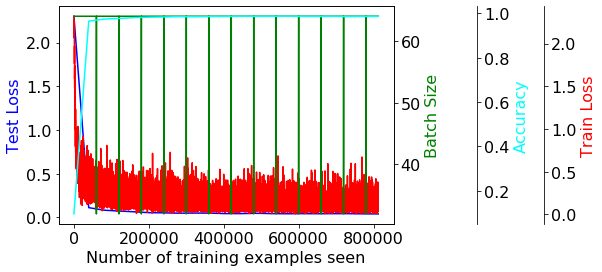

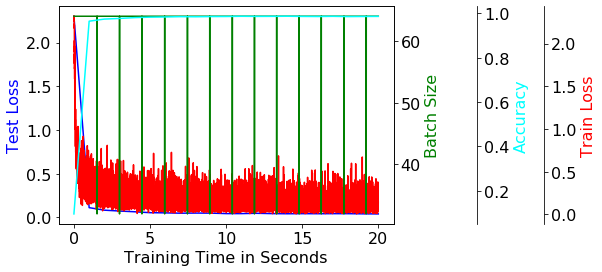

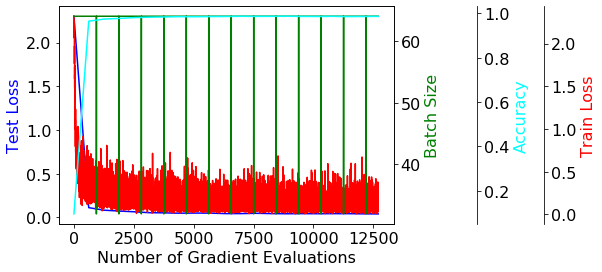

In [0]:
pickle_in = open(tuningResultsPath+"/sgd.results", "rb")
sgd_results = pickle.load(pickle_in)

tuned_sgd_hyperparameters, tuned_sgd_bookkeeper = min(sgd_results, key=last_test_loss)

print(f"tuned_sgd_hyperparameters = {tuned_sgd_hyperparameters}")
tuned_sgd_bookkeeper.plot_data_results('SGD - Data Plot.png')
tuned_sgd_bookkeeper.plot_time_results('SGD - Time Plot.png')
tuned_sgd_bookkeeper.plot_grad_results('SGD - Gradients Plot.png')

In [0]:
class OURLBFGSExecutor(Executor):
    def __init__(self, train_loader, hyperparameters):
        super(OURLBFGSExecutor, self).__init__(train_loader)
        self.optimizer = ProgressiveBatchingLBFGS(params=self.model.parameters(), 
                                                 initial_batch_size=hyperparameters.batch_size, 
                                                 memory_size=hyperparameters.memory_size, 
                                                 armijo_alpha=hyperparameters.armijo_alpha, 
                                                 max_iterations=hyperparameters.max_iter)

In [0]:
torch.manual_seed(seed)

our_lbfgs_possible_hyperparameters = itertools.product(our_lbfgs_batch_sizes, our_lbfgs_memory_sizes, our_lbfgs_armijo_alphas, 
                                                      our_lbfgs_max_iters)
our_lbfgs_tuning_results = []

for (batch_size, memory_size, armijo_alpha, max_iter) in our_lbfgs_possible_hyperparameters:
    print(f"Batch Size = {batch_size}, Memory Size = {memory_size}, Armijo Alpha = {armijo_alpha}, Max. Iterations per Batch = {max_iter}")
    hyperparameters = argparse.Namespace(batch_size=batch_size, memory_size=memory_size, armijo_alpha=armijo_alpha, 
                                         max_iter=max_iter)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, **dataloader_fixed_args)
    executor = OURLBFGSExecutor(train_loader, hyperparameters)
    executor.tune(tuning_time_in_sec)
    if not math.isnan(executor.bookkeeper.test_losses[-1]):
      our_lbfgs_tuning_results.append((hyperparameters, executor.bookkeeper))
    print("-----------------------------------------------------------------------")

pickle_out = open(tuningResultsPath + "/our_lbfgs.results", "wb")
pickle.dump(our_lbfgs_tuning_results, pickle_out)
pickle_out.close()

Batch Size = 1000, Memory Size = 64, Armijo Alpha = 1, Max. Iterations per Batch = 1
cuda

Test set: Average loss: 2.3168, Accuracy: 664/10000 (7%)

Train Epoch: 1 [1000/60000 (2%)]             Loss: 2.322209
Train Time: 0.131 seconds                    Batch Size = 1000

Test set: Average loss: 2.3163, Accuracy: 660/10000 (7%)

Train Epoch: 1 [40000/60000 (67%)]           Loss: 2.335153
Train Time: 1.028 seconds                    Batch Size = 1000

Test set: Average loss: 2.1869, Accuracy: 2243/10000 (22%)

Train Epoch: 2 [19000/60000 (32%)]           Loss: 2.231503
Train Time: 2.046 seconds                    Batch Size = 1000

Test set: Average loss: 2.1869, Accuracy: 2243/10000 (22%)

Train Epoch: 2 [56000/60000 (93%)]           Loss: 2.245281
Train Time: 3.050 seconds                    Batch Size = 1000

Test set: Average loss: 2.1839, Accuracy: 2032/10000 (20%)

Train Epoch: 3 [34000/60000 (57%)]           Loss: 2.244965
Train Time: 4.077 seconds                    Batch Size =

tuned_our_lbfgs_hyperparameters = Namespace(armijo_alpha=256, batch_size=4000, max_iter=20, memory_size=64)


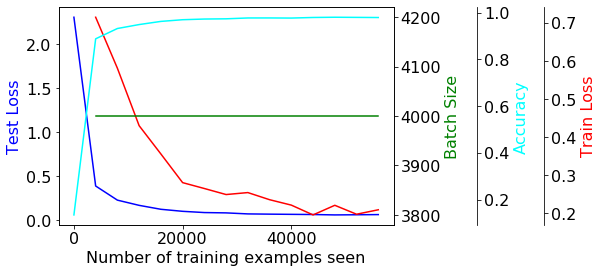

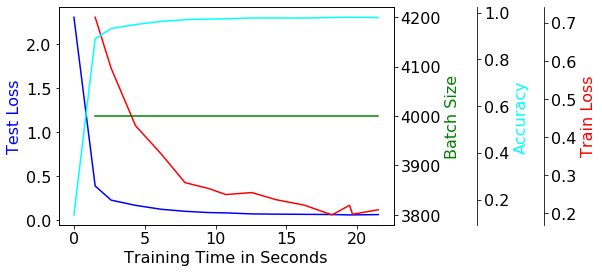

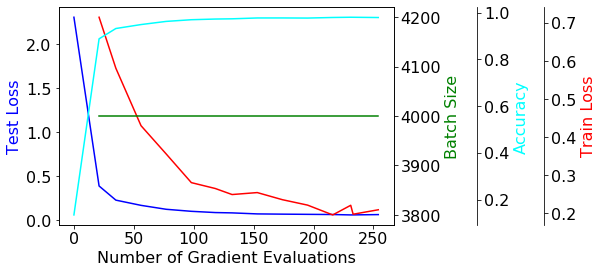

In [0]:
pickle_in = open(tuningResultsPath+"/our_lbfgs.results", "rb")
our_lbfgs_results = pickle.load(pickle_in)

tuned_our_lbfgs_hyperparameters, tuned_our_lbfgs_bookkeeper = min(our_lbfgs_results, key=last_test_loss)

print(f"tuned_our_lbfgs_hyperparameters = {tuned_our_lbfgs_hyperparameters}")
tuned_our_lbfgs_bookkeeper.plot_data_results('Our L-BFGS - Data Plot.png')
tuned_our_lbfgs_bookkeeper.plot_time_results('Our L-BFGS - Time Plot.png')
tuned_our_lbfgs_bookkeeper.plot_grad_results('Our L-BFGS - Gradients Plot.png')

In [0]:
class OURLBFGSLRExecutor(Executor):
    def __init__(self, train_loader, hyperparameters):
        super(OURLBFGSLRExecutor, self).__init__(train_loader)
        self.optimizer = ProgressiveBatchingLBFGS(params=self.model.parameters(), 
                                                 initial_batch_size=hyperparameters.batch_size, 
                                                 memory_size=hyperparameters.memory_size,  
                                                 max_iterations=hyperparameters.max_iter, 
                                                 learning_rate = hyperparameters.learning_rate)

In [0]:
torch.manual_seed(seed)

if tuned_our_lbfgs_hyperparameters is not None:
    tuned_our_lbfgs_lr_batch_sizes = [tuned_our_lbfgs_hyperparameters.batch_size]
    tuned_our_lbfgs_lr_memory_sizes = [tuned_our_lbfgs_hyperparameters.memory_size]
    tuned_our_lbfgs_lr_max_iters = [tuned_our_lbfgs_hyperparameters.max_iter]
    

our_lbfgs_lr_possible_hyperparameters = itertools.product(tuned_our_lbfgs_lr_batch_sizes, tuned_our_lbfgs_lr_memory_sizes, tuned_our_lbfgs_lr_max_iters, our_lbfgs_lr_learning_rates)
our_lbfgs_lr_tuning_results = []

for (batch_size, memory_size, max_iter, learning_rate) in our_lbfgs_lr_possible_hyperparameters:
    print(f"Batch Size = {batch_size}, Memory Size = {memory_size}, Max. Iterations per Batch = {max_iter}, Learning Rate = {learning_rate}")
    hyperparameters = argparse.Namespace(batch_size=batch_size, memory_size=memory_size, max_iter=max_iter, learning_rate=learning_rate)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, **dataloader_fixed_args)
    executor = OURLBFGSLRExecutor(train_loader, hyperparameters)
    executor.tune(tuning_time_in_sec)
    if not math.isnan(executor.bookkeeper.test_losses[-1]):
      our_lbfgs_lr_tuning_results.append((hyperparameters, executor.bookkeeper))
    print("-----------------------------------------------------------------------")

pickle_out = open(tuningResultsPath + "/our_lbfgs_lr.results", "wb")
pickle.dump(our_lbfgs_lr_tuning_results, pickle_out)
pickle_out.close()

Batch Size = 4000, Memory Size = 64, Max. Iterations per Batch = 20, Learning Rate = 0.01
cuda

Test set: Average loss: 2.3168, Accuracy: 664/10000 (7%)

Train Epoch: 1 [4000/60000 (7%)]             Loss: 2.326770
Train Time: 0.271 seconds                    Batch Size = 4000

Test set: Average loss: 2.3036, Accuracy: 1093/10000 (11%)

Train Epoch: 1 [36000/60000 (60%)]           Loss: 2.309418
Train Time: 1.351 seconds                    Batch Size = 4000

Test set: Average loss: 2.3016, Accuracy: 1113/10000 (11%)

Train Epoch: 2 [16000/60000 (27%)]           Loss: 2.309917
Train Time: 2.285 seconds                    Batch Size = 4000

Test set: Average loss: 2.2981, Accuracy: 1146/10000 (11%)

Train Epoch: 2 [48000/60000 (80%)]           Loss: 2.306614
Train Time: 3.370 seconds                    Batch Size = 4000

Test set: Average loss: 2.2978, Accuracy: 1154/10000 (12%)

Train Epoch: 3 [28000/60000 (47%)]           Loss: 2.303647
Train Time: 4.477 seconds                    Batch

tuned_our_lbfgs_lr_hyperparameters = Namespace(batch_size=4000, learning_rate=1, max_iter=20, memory_size=64)


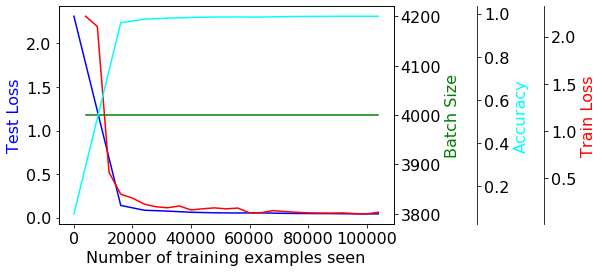

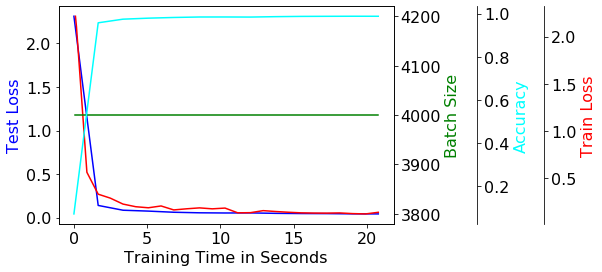

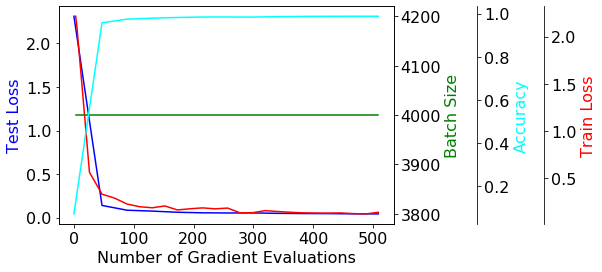

In [0]:
pickle_in = open(tuningResultsPath+"/our_lbfgs_lr.results", "rb")
our_lbfgs_lr_results = pickle.load(pickle_in)

tuned_our_lbfgs_lr_hyperparameters, tuned_our_lbfgs_lr_bookkeeper = min(our_lbfgs_lr_results, key=last_test_loss)

print(f"tuned_our_lbfgs_lr_hyperparameters = {tuned_our_lbfgs_lr_hyperparameters}")
tuned_our_lbfgs_lr_bookkeeper.plot_data_results('Our L-BFGS LR - Data Plot.png')
tuned_our_lbfgs_lr_bookkeeper.plot_time_results('Our L-BFGS LR - Time Plot.png')
tuned_our_lbfgs_lr_bookkeeper.plot_grad_results('Our L-BFGS LR - Gradients Plot.png')

In [0]:
class PTOLBFGSExecutor(Executor):
    def __init__(self, train_loader, hyperparameters):
        super(PTOLBFGSExecutor, self).__init__(train_loader)
        self.optimizer = optim.LBFGS(params=self.model.parameters(), 
                                    lr=hyperparameters.lr, 
                                    history_size=hyperparameters.history_size, 
                                    max_iter=hyperparameters.max_iter)

In [0]:
torch.manual_seed(seed)

#if tuned_our_lbfgs_hyperparameters is not None:
#    tuned_pto_lbfgs_batch_sizes = [tuned_our_lbfgs_hyperparameters.batch_size]
#    tuned_pto_lbfgs_histroy_sizes = [tuned_our_lbfgs_hyperparameters.memory_size]
#    tuned_pto_lbfgs_max_iters = [tuned_our_lbfgs_hyperparameters.max_iter]

pto_lbfgs_possible_hyperparameters = itertools.product(pto_lbfgs_lrs, pto_lbfgs_batch_sizes, pto_lbfgs_history_sizes,
                                                       pto_lbfgs_max_iters)
pto_lbfgs_tuning_results = []

for (lr, batch_size, history_size, max_iter) in pto_lbfgs_possible_hyperparameters:
    print(f"Learning Rate = {lr}, Batch Size = {batch_size}, History Size = {history_size}, Max. Iterations per Batch = {max_iter}")
    hyperparameters = argparse.Namespace(lr=lr, batch_size=batch_size, history_size=history_size, max_iter=max_iter)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, **dataloader_fixed_args)
    executor = PTOLBFGSExecutor(train_loader, hyperparameters)
    executor.tune(tuning_time_in_sec)
    if not math.isnan(executor.bookkeeper.test_losses[-1]):
      pto_lbfgs_tuning_results.append((hyperparameters, executor.bookkeeper))
    print("-----------------------------------------------------------------------")

pickle_out = open(tuningResultsPath + "/pto_lbfgs.results", "wb")
pickle.dump(pto_lbfgs_tuning_results, pickle_out)
pickle_out.close()

Learning Rate = 1, Batch Size = 1000, History Size = 64, Max. Iterations per Batch = 20
cuda

Test set: Average loss: 2.3168, Accuracy: 664/10000 (7%)

Train Epoch: 1 [1000/60000 (2%)]             Loss: 2.332326
Train Time: 0.235 seconds                    Batch Size = 1000

Test set: Average loss: 0.1825, Accuracy: 9463/10000 (95%)

Train Epoch: 1 [5000/60000 (8%)]             Loss: 0.417138
Train Time: 1.659 seconds                    Batch Size = 1000

Test set: Average loss: 0.1429, Accuracy: 9558/10000 (96%)

Train Epoch: 1 [8000/60000 (13%)]            Loss: 0.345971
Train Time: 2.886 seconds                    Batch Size = 1000

Test set: Average loss: 0.1134, Accuracy: 9633/10000 (96%)

Train Epoch: 1 [11000/60000 (18%)]           Loss: 0.376162
Train Time: 4.109 seconds                    Batch Size = 1000

Test set: Average loss: 0.0942, Accuracy: 9692/10000 (97%)

Train Epoch: 1 [14000/60000 (23%)]           Loss: 0.285865
Train Time: 5.335 seconds                    Batch S

tuned_pto_lbfgs_hyperparameters = Namespace(batch_size=4000, history_size=64, lr=1, max_iter=20)


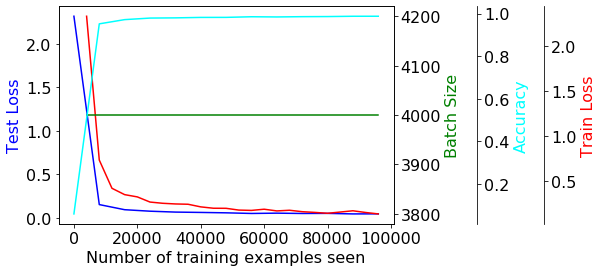

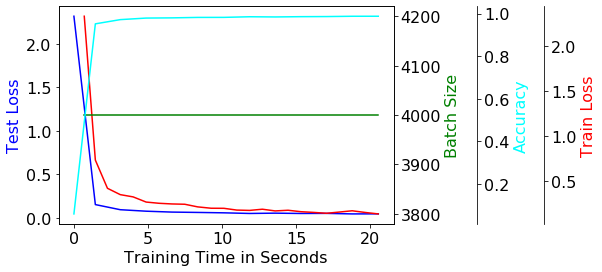

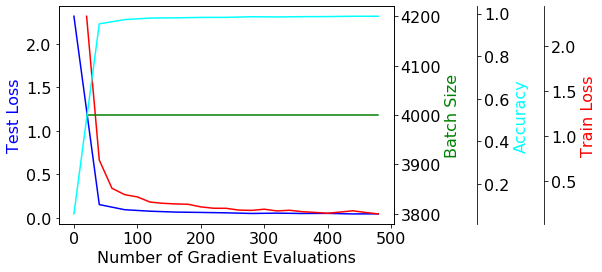

In [0]:
pickle_in = open(tuningResultsPath+"/pto_lbfgs.results", "rb")
pto_lbfgs_results = pickle.load(pickle_in)

tuned_pto_lbfgs_hyperparameters, tuned_pto_lbfgs_bookkeeper = min(pto_lbfgs_results, key=last_test_loss)

print(f"tuned_pto_lbfgs_hyperparameters = {tuned_pto_lbfgs_hyperparameters}")
tuned_pto_lbfgs_bookkeeper.plot_data_results('PyTorch L-BGFGS - Data Plot.png')
tuned_pto_lbfgs_bookkeeper.plot_time_results('PyTorch L-BGFGS - Time Plot.png')
tuned_pto_lbfgs_bookkeeper.plot_grad_results('PyTorch L-BGFGS - Gradients Plot.png')

In [0]:
class GEOMLBFGSExecutor(Executor):
    def __init__(self, train_loader, hyperparameters):
        super(GEOMLBFGSExecutor, self).__init__(train_loader)
        self.dynamic_batching = True
        self.optimizer = ProgressiveBatchingLBFGS(params=self.model.parameters(), 
                                                 geometric_factor=hyperparameters.geometric_factor,
                                                 initial_batch_size=hyperparameters.start_batch_size,
                                                 memory_size=hyperparameters.memory_size, 
                                                 max_iterations=hyperparameters.max_iter, 
                                                 armijo_alpha=hyperparameters.armijo_alpha)

In [0]:
torch.manual_seed(seed)

if tuned_our_lbfgs_hyperparameters is not None:
    tuned_geom_lbfgs_memory_sizes = [tuned_our_lbfgs_hyperparameters.memory_size]
    tuned_geom_lbfgs_max_iters = [tuned_our_lbfgs_hyperparameters.max_iter]
    tuned_geom_lbfgs_armijo_alphas = [tuned_our_lbfgs_hyperparameters.armijo_alpha]

geom_lbfgs_possible_hyperparameters = itertools.product(geom_lbfgs_geometric_factors, geom_lbfgs_start_batch_sizes, 
                                                       tuned_geom_lbfgs_memory_sizes, tuned_geom_lbfgs_max_iters, 
                                                       tuned_geom_lbfgs_armijo_alphas)
geom_lbfgs_tuning_results = []

for (geometric_factor, start_batch_size, memory_size, max_iter, armijo_alpha) in geom_lbfgs_possible_hyperparameters:
    print(f"Geometric Factor = {geometric_factor}, Start Batch Size = {start_batch_size}, Memory Size = {memory_size}, Max. Iterations per Batch = {max_iter}, Armijo Alpha = {armijo_alpha}")
    hyperparameters = argparse.Namespace(geometric_factor=geometric_factor, start_batch_size=start_batch_size, memory_size=memory_size, max_iter=max_iter, armijo_alpha = armijo_alpha)
    train_loader = torch.utils.data.DataLoader(dataset, start_batch_size, shuffle=True, **dataloader_fixed_args)
    executor = GEOMLBFGSExecutor(train_loader, hyperparameters)
    executor.tune(tuning_time_in_sec)
    if not math.isnan(executor.bookkeeper.test_losses[-1]):
      geom_lbfgs_tuning_results.append((hyperparameters, executor.bookkeeper))
    print("-----------------------------------------------------------------------")

pickle_out = open(tuningResultsPath + "/geom_lbfgs.results", "wb")
pickle.dump(geom_lbfgs_tuning_results, pickle_out)
pickle_out.close()

Geometric Factor = 1.1, Start Batch Size = 256, Memory Size = 64, Max. Iterations per Batch = 20, Armijo Alpha = 256
cuda

Test set: Average loss: 2.3168, Accuracy: 664/10000 (7%)

Train Epoch: 1 [256/60000 (0%)]              Loss: 2.289001
Train Time: 0.109 seconds                    Batch Size = 256

Test set: Average loss: 0.4781, Accuracy: 8567/10000 (86%)

Train Epoch: 1 [1977/60000 (3%)]             Loss: 0.833820
Train Time: 1.830 seconds                    Batch Size = 413

Test set: Average loss: 0.3607, Accuracy: 8926/10000 (89%)

Train Epoch: 1 [2930/60000 (5%)]             Loss: 0.735325
Train Time: 2.541 seconds                    Batch Size = 499

Test set: Average loss: 0.2360, Accuracy: 9321/10000 (93%)

Train Epoch: 1 [5478/60000 (9%)]             Loss: 0.576271
Train Time: 3.941 seconds                    Batch Size = 731

Test set: Average loss: 0.1848, Accuracy: 9476/10000 (95%)

Train Epoch: 1 [8139/60000 (14%)]            Loss: 0.362538
Train Time: 5.454 seconds  

tuned_geom_lbfgs_hyperparameters = Namespace(armijo_alpha=256, geometric_factor=1.5, max_iter=20, memory_size=64, start_batch_size=256)


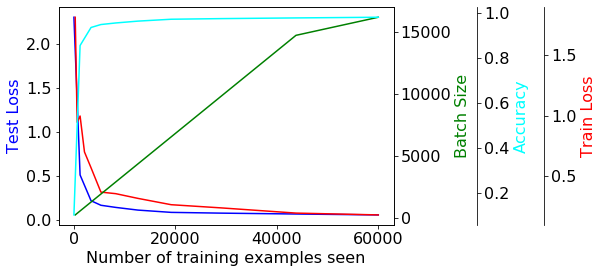

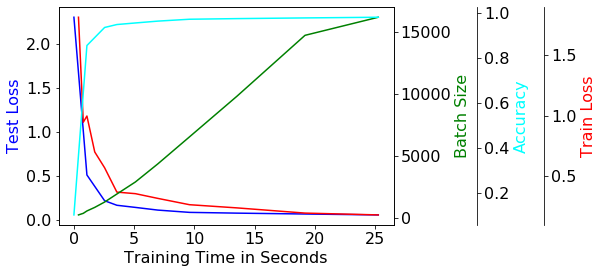

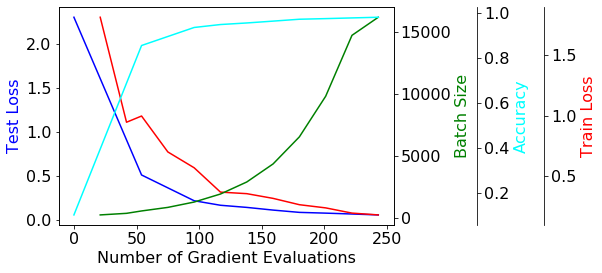

In [0]:
pickle_in = open(tuningResultsPath+"/geom_lbfgs.results", "rb")
geom_lbfgs_results = pickle.load(pickle_in)

tuned_geom_lbfgs_hyperparameters, tuned_geom_lbfgs_bookkeeper = min(geom_lbfgs_results, key=last_test_loss)

print(f"tuned_geom_lbfgs_hyperparameters = {tuned_geom_lbfgs_hyperparameters}")
tuned_geom_lbfgs_bookkeeper.plot_data_results('Geometric L-BGFGS - Data Plot.png')
tuned_geom_lbfgs_bookkeeper.plot_time_results('Geometric L-BGFGS - Time Plot.png')
tuned_geom_lbfgs_bookkeeper.plot_grad_results('Geometric L-BGFGS - Gradients Plot.png')

In [0]:
class PBLBFGSExecutor(Executor):
    def __init__(self, train_loader, hyperparameters):
        super(PBLBFGSExecutor, self).__init__(train_loader)
        self.dynamic_batching = True
        self.max_variance_size = hyperparameters.max_variance_size
        self.optimizer = ProgressiveBatchingLBFGS(params=self.model.parameters(), 
                                                  progressive_batching=True, 
                                                  initial_batch_size=hyperparameters.start_batch_size,
                                                  memory_size=hyperparameters.memory_size, 
                                                  armijo_alpha=hyperparameters.armijo_alpha)

In [0]:
torch.manual_seed(seed)

if tuned_our_lbfgs_hyperparameters is not None:
    tuned_pblbfgs_memory_sizes = [tuned_our_lbfgs_hyperparameters.memory_size]
    tuned_pblbfgs_max_iters = [tuned_our_lbfgs_hyperparameters.max_iter]
    tuned_pblbfgs_armijo_alphas = [tuned_our_lbfgs_hyperparameters.armijo_alpha]

pblbfgs_possible_hyperparameters = itertools.product(pblbfgs_start_batch_sizes, pblbfgs_max_variance_sizes, 
                                                     tuned_pblbfgs_memory_sizes, tuned_pblbfgs_max_iters, 
                                                     tuned_pblbfgs_armijo_alphas)
pblbfgs_tuning_results = []

for (start_batch_size, max_variance_size, memory_size, max_iter, armijo_alpha) in pblbfgs_possible_hyperparameters:
    print(f"Start Batch Size = {start_batch_size}, Max. Variance Size = {max_variance_size}, Memory Size = {memory_size}, Max. Iterations per Batch = {max_iter}. Armijo Alpha = {armijo_alpha}")
    hyperparameters = argparse.Namespace(start_batch_size=start_batch_size, max_variance_size=max_variance_size, 
                                         memory_size=memory_size, armijo_alpha=armijo_alpha, max_iter=max_iter)
    train_loader = torch.utils.data.DataLoader(dataset, start_batch_size, shuffle=True, **dataloader_fixed_args)
    executor = PBLBFGSExecutor(train_loader, hyperparameters)
    executor.tune(tuning_time_in_sec)
    if not math.isnan(executor.bookkeeper.test_losses[-1]):
      pblbfgs_tuning_results.append((hyperparameters, executor.bookkeeper))
    print("-----------------------------------------------------------------------")

pickle_out = open(tuningResultsPath + "/pblbfgs.results", "wb")
pickle.dump(pblbfgs_tuning_results, pickle_out)
pickle_out.close()

Start Batch Size = 256, Max. Variance Size = 16, Memory Size = 64, Max. Iterations per Batch = 20. Armijo Alpha = 256
cuda

Test set: Average loss: 2.3168, Accuracy: 664/10000 (7%)

Train Epoch: 1 [256/60000 (0%)]              Loss: 2.289001
Train Time: 0.179 seconds                    Batch Size = 256

Test set: Average loss: 0.6167, Accuracy: 8313/10000 (83%)

Train Epoch: 1 [1024/60000 (2%)]             Loss: 0.802493
Train Time: 1.867 seconds                    Batch Size = 256

Test set: Average loss: 0.4700, Accuracy: 8645/10000 (86%)

Train Epoch: 1 [4250/60000 (7%)]             Loss: 0.578595
Train Time: 3.393 seconds                    Batch Size = 1613

Test set: Average loss: 0.3015, Accuracy: 9158/10000 (92%)

Train Epoch: 1 [5863/60000 (10%)]            Loss: 0.402083
Train Time: 4.441 seconds                    Batch Size = 1613

Test set: Average loss: 0.1741, Accuracy: 9492/10000 (95%)

Train Epoch: 1 [7476/60000 (12%)]            Loss: 0.405044
Train Time: 5.616 second

tuned_pblbfgs_hyperparameters = Namespace(armijo_alpha=256, max_iter=20, max_variance_size=16, memory_size=64, start_batch_size=256)


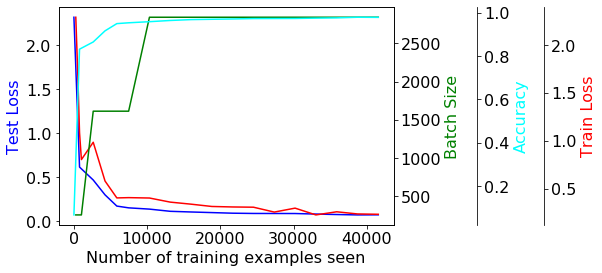

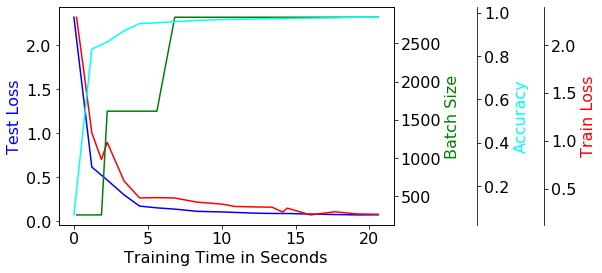

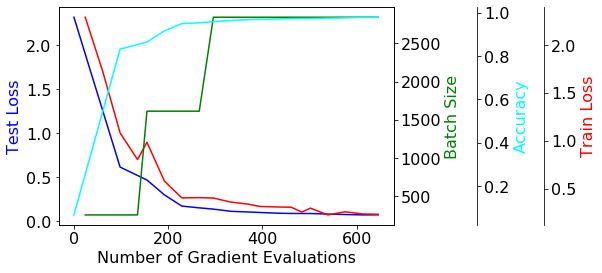

In [0]:
pickle_in = open(tuningResultsPath+"/pblbfgs.results", "rb")
pblbfgs_results = pickle.load(pickle_in)

tuned_pblbfgs_hyperparameters, tuned_pblbfgs_bookkeeper = min(pblbfgs_results, key=last_test_loss)

print(f"tuned_pblbfgs_hyperparameters = {tuned_pblbfgs_hyperparameters}")
tuned_pblbfgs_bookkeeper.plot_data_results('Progressive Batching L-BGFGS - Data Plot.png')
tuned_pblbfgs_bookkeeper.plot_time_results('Progressive Batching L-BGFGS - Time Plot.png')
tuned_pblbfgs_bookkeeper.plot_grad_results('Progressive Batching L-BGFGS - Gradients Plot.png')

In [0]:
class GEOMPBLBFGSExecutor(Executor):
    def __init__(self, train_loader, hyperparameters):
        super(GEOMPBLBFGSExecutor, self).__init__(train_loader)
        self.dynamic_batching = True
        self.max_variance_size = hyperparameters.max_variance_size
        self.optimizer = ProgressiveBatchingLBFGS(params=self.model.parameters(), 
                                                  progressive_batching=True, 
                                                  initial_batch_size=hyperparameters.start_batch_size, 
                                                  memory_size=hyperparameters.memory_size, 
                                                  armijo_alpha=hyperparameters.armijo_alpha, 
                                                  geometric_factor=hyperparameters.geometric_factor)

In [0]:
torch.manual_seed(seed)

if tuned_geom_lbfgs_hyperparameters is not None:
    tuned_geom_pblbfgs_geometric_factor = tuned_geom_lbfgs_hyperparameters.geometric_factor
    
if tuned_pblbfgs_hyperparameters is not None: 
    tuned_geom_pblbfgs_start_batch_size = tuned_pblbfgs_hyperparameters.start_batch_size
    tuned_geom_pblbfgs_max_variance_size = tuned_pblbfgs_hyperparameters.max_variance_size

if tuned_our_lbfgs_hyperparameters is not None:
    tuned_geom_pblbfgs_memory_size = tuned_our_lbfgs_hyperparameters.memory_size
    tuned_geom_pblbfgs_max_iter = tuned_our_lbfgs_hyperparameters.max_iter
    tuned_geom_pblbfgs_armijo_alpha = tuned_our_lbfgs_hyperparameters.armijo_alpha

print(f"Geometric Factor = {tuned_geom_pblbfgs_geometric_factor}, Start Batch Size = {tuned_geom_pblbfgs_start_batch_size}, Max. Variance Size = {tuned_geom_pblbfgs_max_variance_size}, Memory Size = {tuned_geom_pblbfgs_memory_size}, Max. Iterations per Batch = {tuned_geom_pblbfgs_max_iter}, Armijo Alpha = {tuned_geom_pblbfgs_armijo_alpha}")
hyperparameters = argparse.Namespace(start_batch_size=tuned_geom_pblbfgs_start_batch_size, 
                                     max_variance_size=tuned_geom_pblbfgs_max_variance_size, 
                                     memory_size=tuned_geom_pblbfgs_memory_size, 
                                     armijo_alpha=tuned_geom_pblbfgs_armijo_alpha, 
                                     max_iter=tuned_geom_pblbfgs_max_iter, 
                                     geometric_factor=tuned_geom_pblbfgs_geometric_factor)

geom_pblbfgs_tuning_results = []

train_loader = torch.utils.data.DataLoader(dataset, tuned_geom_pblbfgs_start_batch_size, shuffle=True, **dataloader_fixed_args)
executor = GEOMPBLBFGSExecutor(train_loader, hyperparameters)
executor.tune(tuning_time_in_sec)

if not math.isnan(executor.bookkeeper.test_losses[-1]):
      geom_pblbfgs_tuning_results.append((hyperparameters, executor.bookkeeper))

pickle_out = open(tuningResultsPath + "/geom_pblbfgs.results", "wb")
pickle.dump(geom_pblbfgs_tuning_results, pickle_out)
pickle_out.close()

Geometric Factor = 1.5, Start Batch Size = 256, Max. Variance Size = 16, Memory Size = 64, Max. Iterations per Batch = 20, Armijo Alpha = 256
cuda

Test set: Average loss: 2.3168, Accuracy: 664/10000 (7%)

Train Epoch: 1 [256/60000 (0%)]              Loss: 2.289001
Train Time: 0.154 seconds                    Batch Size = 256

Test set: Average loss: 0.4246, Accuracy: 8796/10000 (88%)

Train Epoch: 1 [2080/60000 (3%)]             Loss: 0.647083
Train Time: 2.055 seconds                    Batch Size = 864

Test set: Average loss: 0.2285, Accuracy: 9340/10000 (93%)

Train Epoch: 1 [5320/60000 (9%)]             Loss: 0.550671
Train Time: 3.411 seconds                    Batch Size = 1944

Test set: Average loss: 0.1765, Accuracy: 9472/10000 (95%)

Train Epoch: 1 [12610/60000 (21%)]           Loss: 0.404920
Train Time: 7.121 seconds                    Batch Size = 4374

Test set: Average loss: 0.1448, Accuracy: 9563/10000 (96%)

Train Epoch: 1 [19171/60000 (32%)]           Loss: 0.310933


tuned_geom_pblbfgs_hyperparameters = Namespace(armijo_alpha=256, geometric_factor=1.5, max_iter=20, max_variance_size=16, memory_size=64, start_batch_size=256)


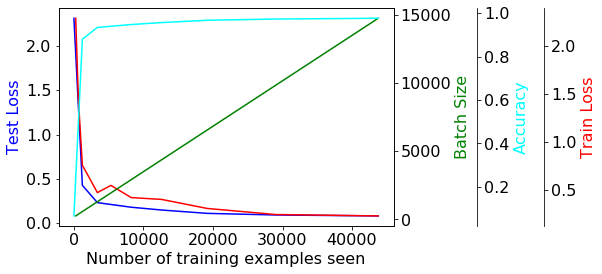

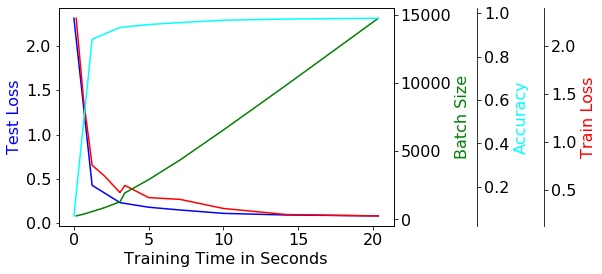

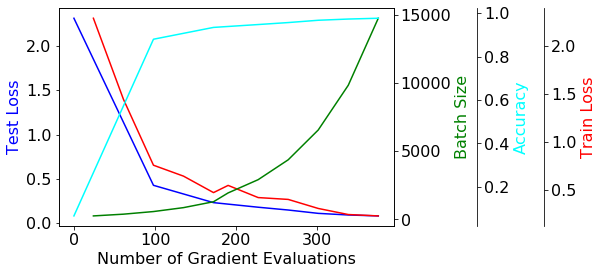

In [0]:
pickle_in = open(tuningResultsPath+"/geom_pblbfgs.results", "rb")
geom_pblbfgs_results = pickle.load(pickle_in)

tuned_geom_pblbfgs_hyperparameters, tuned_geom_pblbfgs_bookkeeper = min(geom_pblbfgs_results, key=last_test_loss)

print(f"tuned_geom_pblbfgs_hyperparameters = {tuned_geom_pblbfgs_hyperparameters}")
tuned_geom_pblbfgs_bookkeeper.plot_data_results('Geometric Progressive Batching L-BGFGS - Data Plot.png')
tuned_geom_pblbfgs_bookkeeper.plot_time_results('Geometric Progressive Batching L-BGFGS - Time Plot.png')
tuned_geom_pblbfgs_bookkeeper.plot_grad_results('Geometric Progressive Batching L-BGFGS - Gradients Plot.png')

In [0]:
class AlphaPBLBFGSExecutor(Executor):
    def __init__(self, train_loader, hyperparameters):
        super(AlphaPBLBFGSExecutor, self).__init__(train_loader)
        self.dynamic_batching = True
        self.max_variance_size = hyperparameters.max_variance_size
        self.optimizer = ProgressiveBatchingLBFGS(params=self.model.parameters(), 
                                                  progressive_batching=True, 
                                                  initial_batch_size=hyperparameters.start_batch_size, 
                                                  memory_size=hyperparameters.memory_size,
                                                  max_iterations=hyperparameters.max_iter)

In [0]:
torch.manual_seed(seed)
  
if tuned_pblbfgs_hyperparameters is not None: 
    tuned_alpha_pblbfgs_start_batch_size = tuned_pblbfgs_hyperparameters.start_batch_size
    tuned_alpha_pblbfgs_max_variance_size = tuned_pblbfgs_hyperparameters.max_variance_size

if tuned_our_lbfgs_hyperparameters is not None:
    tuned_alpha_pblbfgs_memory_size = tuned_our_lbfgs_hyperparameters.memory_size
    tuned_alpha_pblbfgs_max_iter = tuned_our_lbfgs_hyperparameters.max_iter

print(f"Start Batch Size = {tuned_alpha_pblbfgs_start_batch_size}, Max. Variance Size = {tuned_alpha_pblbfgs_max_variance_size}, Memory Size = {tuned_alpha_pblbfgs_memory_size}, Max. Iterations per Batch = {tuned_alpha_pblbfgs_max_iter}")
hyperparameters = argparse.Namespace(start_batch_size=tuned_alpha_pblbfgs_start_batch_size, 
                                     max_variance_size=tuned_alpha_pblbfgs_max_variance_size, 
                                     memory_size=tuned_alpha_pblbfgs_memory_size, 
                                     max_iter=tuned_alpha_pblbfgs_max_iter)

alpha_pblbfgs_tuning_results = []

train_loader = torch.utils.data.DataLoader(dataset, tuned_alpha_pblbfgs_start_batch_size, shuffle=True, **dataloader_fixed_args)
executor = AlphaPBLBFGSExecutor(train_loader, hyperparameters)
executor.tune(tuning_time_in_sec)

if not math.isnan(executor.bookkeeper.test_losses[-1]):
      alpha_pblbfgs_tuning_results.append((hyperparameters, executor.bookkeeper))

pickle_out = open(tuningResultsPath + "/alpha_pblbfgs.results", "wb")
pickle.dump(alpha_pblbfgs_tuning_results, pickle_out)
pickle_out.close()

Start Batch Size = 256, Max. Variance Size = 16, Memory Size = 64, Max. Iterations per Batch = 20
cuda

Test set: Average loss: 2.3168, Accuracy: 664/10000 (7%)

Train Epoch: 1 [256/60000 (0%)]              Loss: 2.303527
Train Time: 0.405 seconds                    Batch Size = 256

Test set: Average loss: 2.0776, Accuracy: 2302/10000 (23%)

Train Epoch: 1 [768/60000 (1%)]              Loss: 1.399976
Train Time: 2.194 seconds                    Batch Size = 256

Test set: Average loss: 0.5989, Accuracy: 8267/10000 (83%)

Train Epoch: 1 [2523/60000 (4%)]             Loss: 0.763014
Train Time: 4.644 seconds                    Batch Size = 1499

Test set: Average loss: 0.3708, Accuracy: 8927/10000 (89%)

Train Epoch: 1 [4022/60000 (7%)]             Loss: 0.611437
Train Time: 5.937 seconds                    Batch Size = 1499

Test set: Average loss: 0.2522, Accuracy: 9285/10000 (93%)

Train Epoch: 1 [5521/60000 (9%)]             Loss: 0.538057
Train Time: 7.256 seconds                   

tuned_alpha_pblbfgs_hyperparameters = Namespace(max_iter=20, max_variance_size=16, memory_size=64, start_batch_size=256)


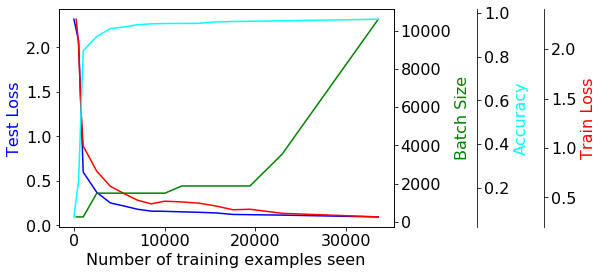

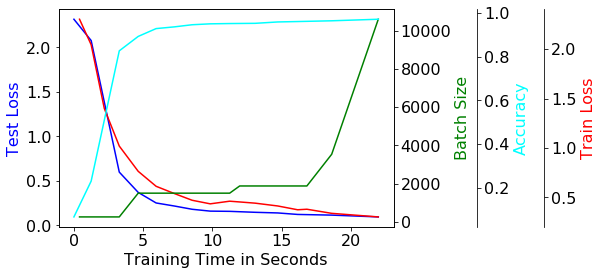

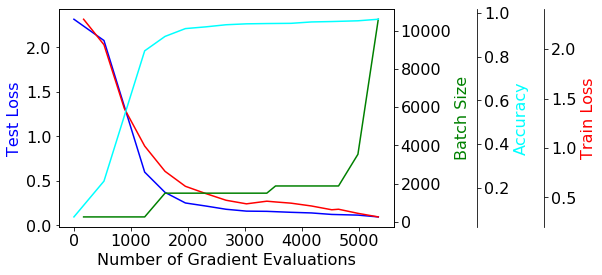

In [0]:
pickle_in = open(tuningResultsPath+"/alpha_pblbfgs.results", "rb")
alpha_pblbfgs_results = pickle.load(pickle_in)

tuned_alpha_pblbfgs_hyperparameters, tuned_alpha_pblbfgs_bookkeeper = min(alpha_pblbfgs_results, key=last_test_loss)

print(f"tuned_alpha_pblbfgs_hyperparameters = {tuned_alpha_pblbfgs_hyperparameters}")
tuned_alpha_pblbfgs_bookkeeper.plot_data_results('Alpha Progressive Batching L-BGFGS - Data Plot.png')
tuned_alpha_pblbfgs_bookkeeper.plot_time_results('Alpha Progressive Batching L-BGFGS - Time Plot.png')
tuned_alpha_pblbfgs_bookkeeper.plot_grad_results('Alpha Progressive Batching L-BGFGS - Gradients Plot.png')

In [0]:
def compare_results(xAxis="data", yAxis="test", window=None):
  xLabel = "x Axis"
  yLabel = "y Axis"

  if xAxis == "data":
    xLabel = "Number of training examples seen"
  elif xAxis == "time":
    xLabel = "Time in seconds"
  elif xAxis == "gradients":
    xLabel = "Number of Gradient Evaluations"

  if yAxis == "test":
    yLabel = "Test loss"
  elif yAxis == "accuracy":
    yLabel = "Accuracy"
  elif yAxis == "train":
    yLabel = "Train loss"
  
  zoom = ""
  if window is not None:
    zoom = " zoomed"

  filename = "plot " + yLabel + " per " + xLabel + zoom

  print("Joint graph of the " + yLabel + " of all methods per " + xLabel + " :")
  plt.figure(figsize=(10,7))
  plt.xlabel(xLabel)
  plt.ylabel(yLabel)
  sgd_data = tuned_sgd_bookkeeper.getData(xAxis, yAxis)
  pto_lbfgs_data = tuned_pto_lbfgs_bookkeeper.getData(xAxis, yAxis)
  our_lbfgs_data = tuned_our_lbfgs_bookkeeper.getData(xAxis, yAxis)
  our_lbfgs_lr_data = tuned_our_lbfgs_lr_bookkeeper.getData(xAxis, yAxis)
  geom_lbfgs_data = tuned_geom_lbfgs_bookkeeper.getData(xAxis, yAxis)
  pblbfgs_data = tuned_pblbfgs_bookkeeper.getData(xAxis, yAxis)
  geom_pblbfgs_data = tuned_geom_pblbfgs_bookkeeper.getData(xAxis, yAxis)
  alpha_pblbfgs_data = tuned_alpha_pblbfgs_bookkeeper.getData(xAxis, yAxis)

  sgd_plot, = plt.plot(sgd_data[0], sgd_data[1], c = 'blue')
  pto_lbfgs_plot, = plt.plot(pto_lbfgs_data[0], pto_lbfgs_data[1], c = 'red')
  our_lbfgs_plot, = plt.plot(our_lbfgs_data[0], our_lbfgs_data[1], c = 'green')
  our_lbfgs_lr_plot, = plt.plot(our_lbfgs_lr_data[0], our_lbfgs_lr_data[1], c = 'darkred')
  geom_lbfgs_plot, = plt.plot(geom_lbfgs_data[0], geom_lbfgs_data[1], c = 'black')
  pblbfgs_plot, = plt.plot(pblbfgs_data[0], pblbfgs_data[1], c = 'darkkhaki')
  geom_pblbfgs_plot, = plt.plot(geom_pblbfgs_data[0], geom_pblbfgs_data[1], c = 'magenta')
  alpha_pblbfgs_plot, = plt.plot(alpha_pblbfgs_data[0], alpha_pblbfgs_data[1], c = 'cyan')
  plt.legend([sgd_plot, pto_lbfgs_plot, our_lbfgs_plot, our_lbfgs_lr_plot, geom_lbfgs_plot, pblbfgs_plot, geom_pblbfgs_plot, alpha_pblbfgs_plot], ['PyTorch SGD', 'PyTorch L-BFGS', 'Our L-BFGS', 'Our L-BFGS LR', 'Geometric L-BFGS', 'Progressive Batching L-BFGS', 
                  'Geometric Progressive Batching L-BFGS', 'Alpha Progressive Batching L-BFGS'])
  if window is not None:
    plt.axis(window)
  
  plt.savefig(plotsPath + "Comparison/" + filename, dpi=150, bbox_inches='tight')

Joint graph of the Test loss of all methods per Number of training examples seen :


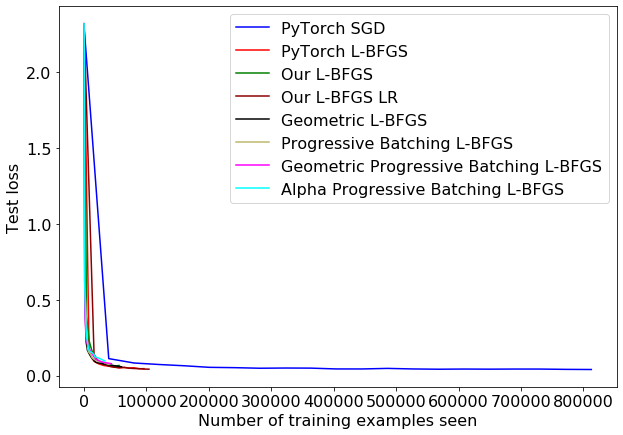

In [0]:
compare_results(xAxis="data", yAxis="test")

Joint graph of the Test loss of all methods per Number of training examples seen :


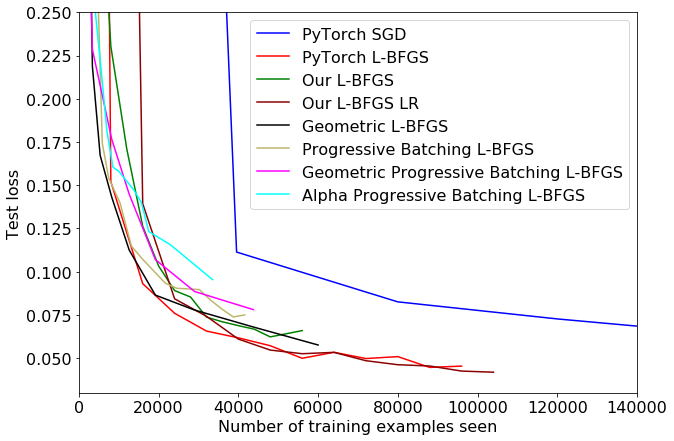

In [0]:
compare_results(xAxis="data", yAxis="test", window=(0,140000,0.03,0.25))

Joint graph of the Accuracy of all methods per Number of training examples seen :


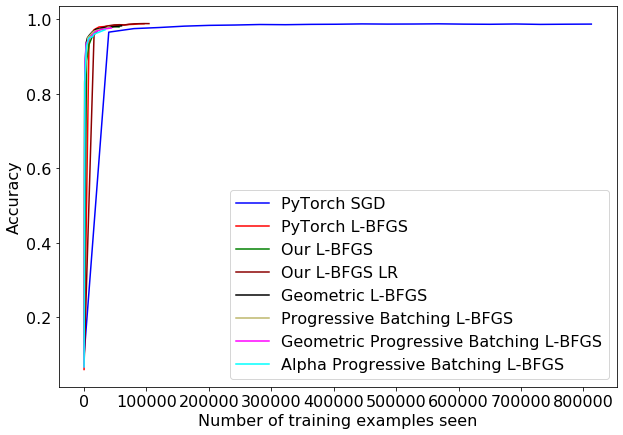

In [0]:
compare_results(xAxis="data", yAxis="accuracy")

Joint graph of the Accuracy of all methods per Number of training examples seen :


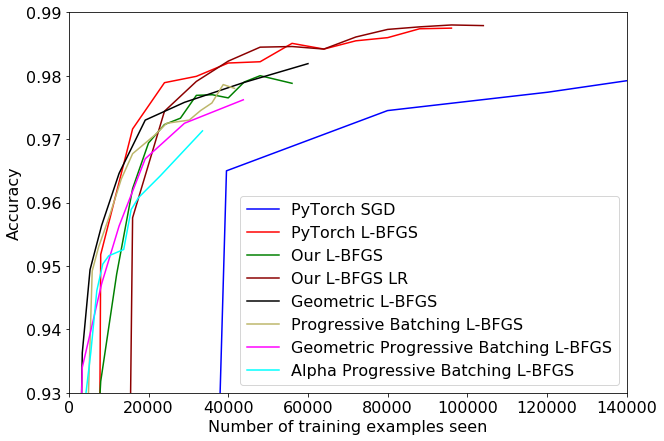

In [0]:
compare_results(xAxis="data", yAxis="accuracy", window=(0, 140000, 0.93, 0.99))

Joint graph of the Train loss of all methods per Number of training examples seen :


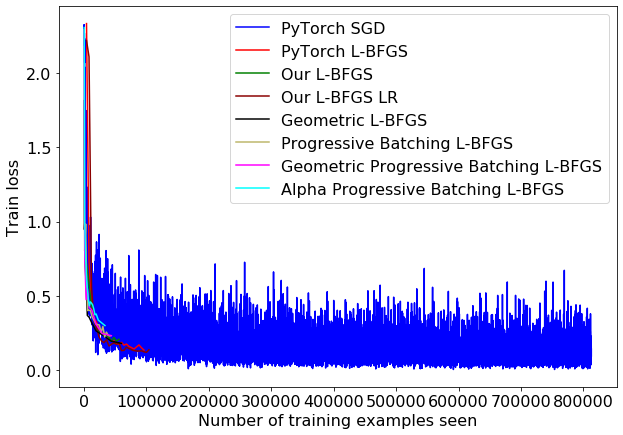

In [0]:
compare_results(xAxis="data", yAxis="train")

Joint graph of the Train loss of all methods per Number of training examples seen :


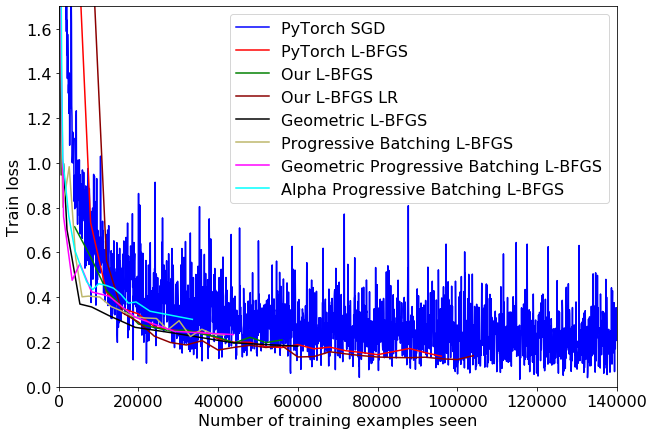

In [0]:
compare_results(xAxis="data", yAxis="train", window=(0, 140000, 0, 1.7))

Joint graph of the Test loss of all methods per Time in seconds :


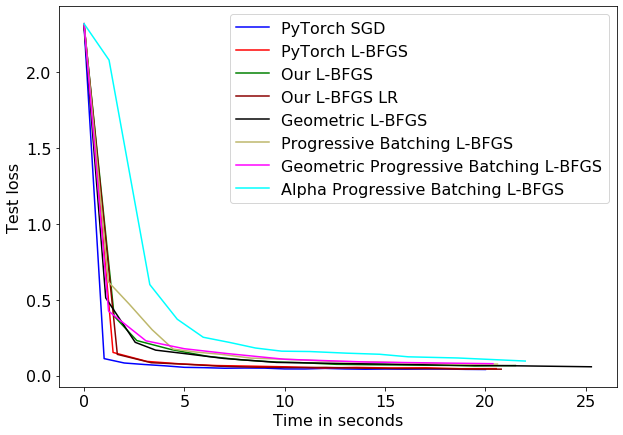

In [0]:
compare_results(xAxis="time", yAxis="test")

Joint graph of the Test loss of all methods per Time in seconds :


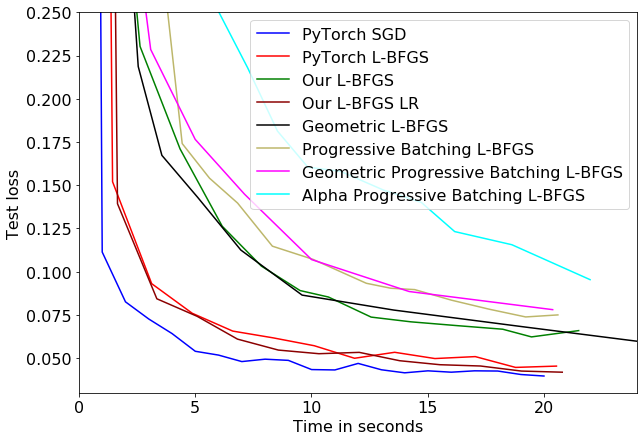

In [0]:
compare_results(xAxis="time", yAxis="test", window=(0, 24, 0.03, 0.25))

Joint graph of the Accuracy of all methods per Time in seconds :


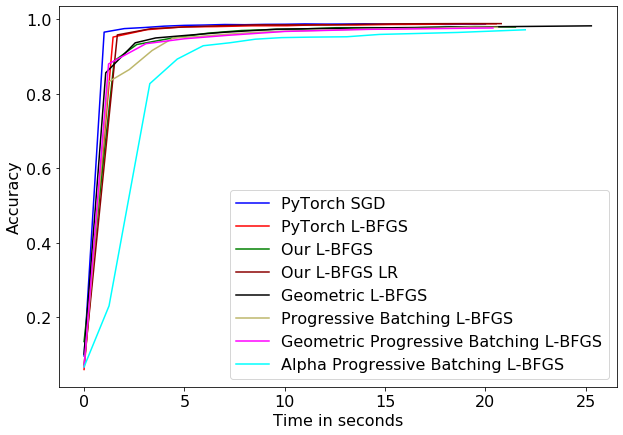

In [0]:
compare_results(xAxis="time", yAxis="accuracy")

Joint graph of the Accuracy of all methods per Time in seconds :


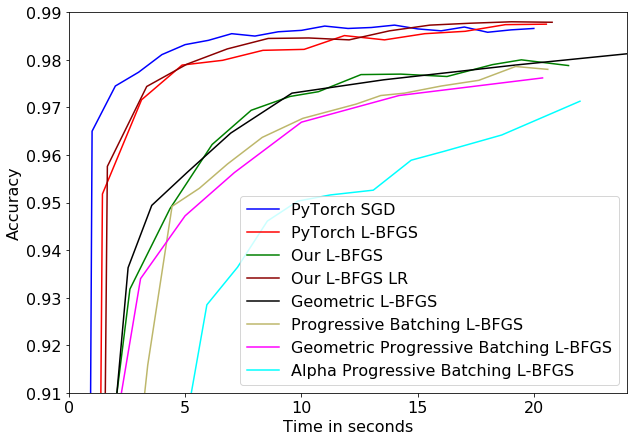

In [0]:
compare_results(xAxis="time", yAxis="accuracy", window=(0, 24, 0.91, 0.99))

Joint graph of the Train loss of all methods per Time in seconds :


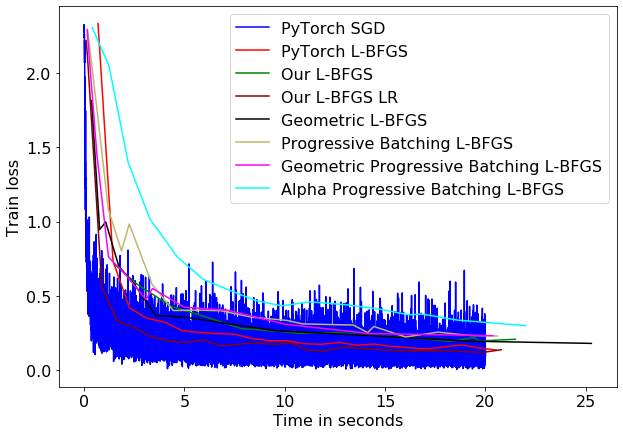

In [0]:
compare_results(xAxis="time", yAxis="train")

Joint graph of the Train loss of all methods per Time in seconds :


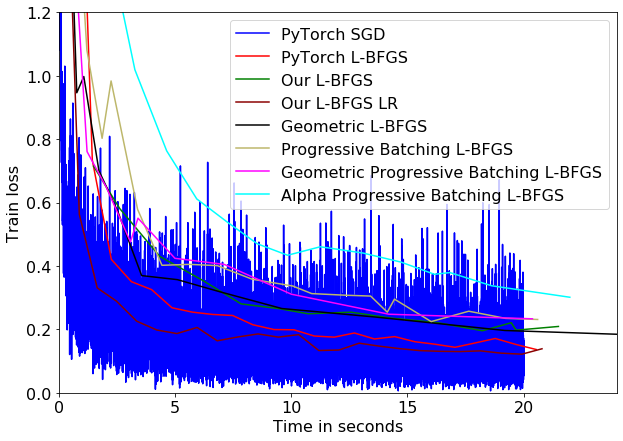

In [0]:
compare_results(xAxis="time", yAxis="train", window=(0, 24, 0, 1.2))

Joint graph of the Test loss of all methods per Number of Gradient Evaluations :


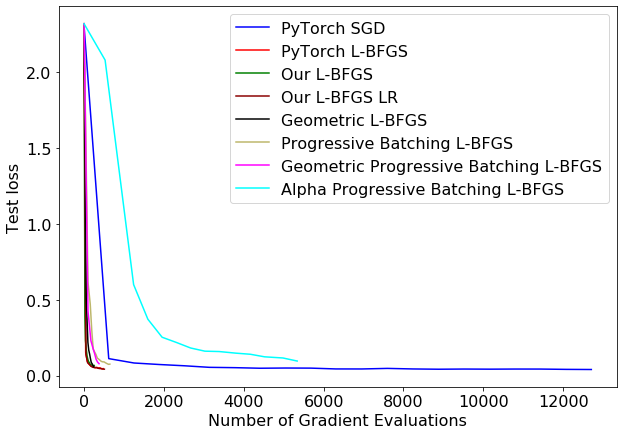

In [0]:
compare_results(xAxis="gradients", yAxis="test")

Joint graph of the Test loss of all methods per Number of Gradient Evaluations :


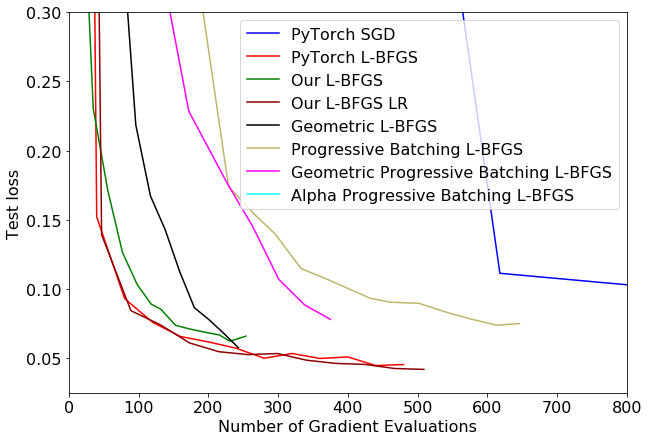

In [0]:
compare_results(xAxis="gradients", yAxis="test", window=(0, 800, 0.025, 0.3))

Joint graph of the Accuracy of all methods per Number of Gradient Evaluations :


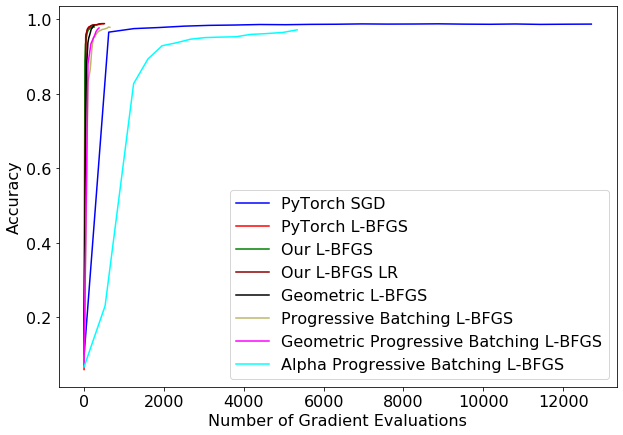

In [0]:
compare_results(xAxis="gradients", yAxis="accuracy")

Joint graph of the Accuracy of all methods per Number of Gradient Evaluations :


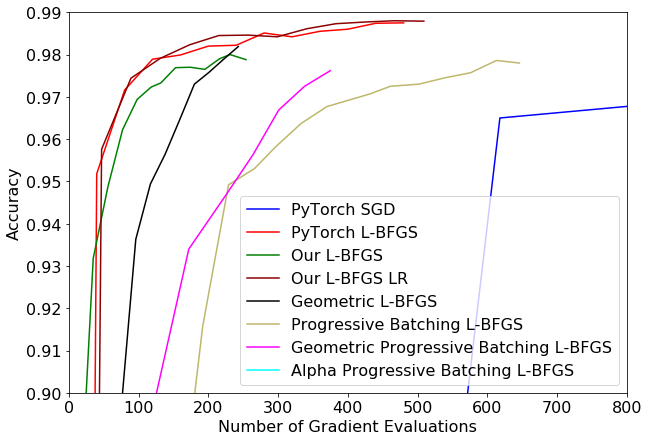

In [0]:
compare_results(xAxis="gradients", yAxis="accuracy", window=(0, 800, 0.9, 0.99))

Joint graph of the Train loss of all methods per Number of Gradient Evaluations :


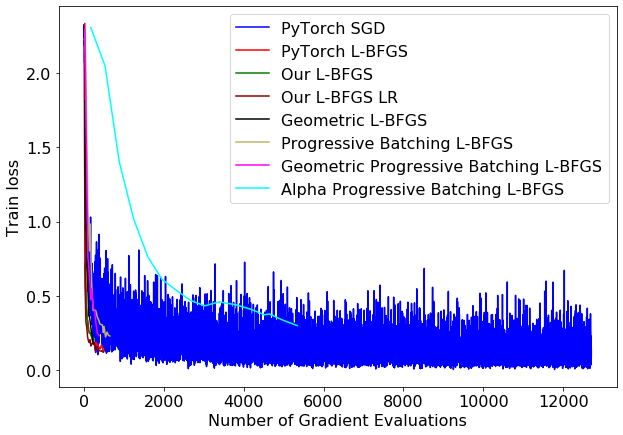

In [0]:
compare_results(xAxis="gradients", yAxis="train")

Joint graph of the Train loss of all methods per Number of Gradient Evaluations :


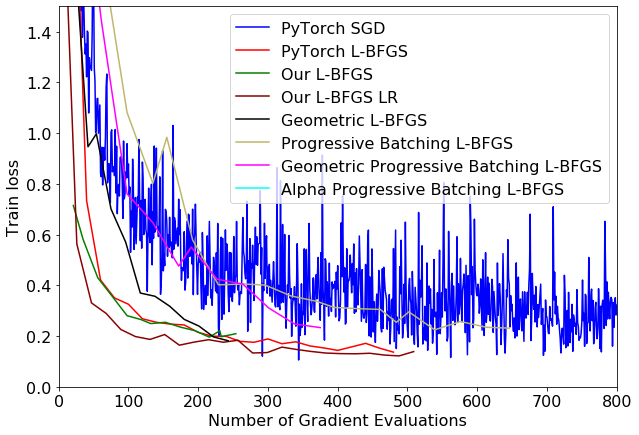

In [0]:
compare_results(xAxis="gradients", yAxis="train", window=(0, 800, 0, 1.5))